# Tutorial \#2: Integrating Geo2SigMap with Sionna RT - Ray Tracing with Detailed Analysis and Link-Level Simulations

This notebook provides an example of using Sionna RT to generate the point-to-point rays for the target area generated using our scene generation framework. This example contains seven modules:

1. **Load and Preview** the generated scene for the target area;
2. **Generate** random receiver (RX) locations in outdoor environments;
3. **Configure** the transmitters (TXs) and receivers (RXs);
4. **Compute** path (rays) for each TX-RX pair;
5. **Visualize** the paths (rays) using Sionna's built-in functions;
6. **Save** the raw information for individual rays;
7. **Analyze** the generated rays;
8. **Link-level Simulations** using generated channel impulse response (CIR).


Please make sure that you have properly installed Sionna:
```console
python3 -m pip install sionna
```

In [1]:
# Core imports
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, PathSolver
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Mitsuba components for advanced scene operation
import mitsuba as mi
import drjit as dr
import trimesh

## 1. **Load and Preview** the target scene

We assume you have prepared the 3D scene XML file corresponding to the target area generated with our CLI tool `scenegen`, check the `README.md` of this repo for details. 

You can use the following controls:
* Mouse left: Rotate
* Scroll wheel: Zoom
* Mouse right: Move

In [2]:
# Load scene and access Mitsuba's internal representation
scene = load_scene("../scenes/Boston/scene.xml")

# Interative 3D visualization and view of the scene
scene.preview();

2025-06-14 14:00:33 WARN wrk4 [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

## 2. **Generate** random RX locations in outdoor environment

- Generate candidate RX locations within the target scene. Note that RXs cannot be located inside a building;
- Filter out potential indoor RX locations using upward ray tracing.

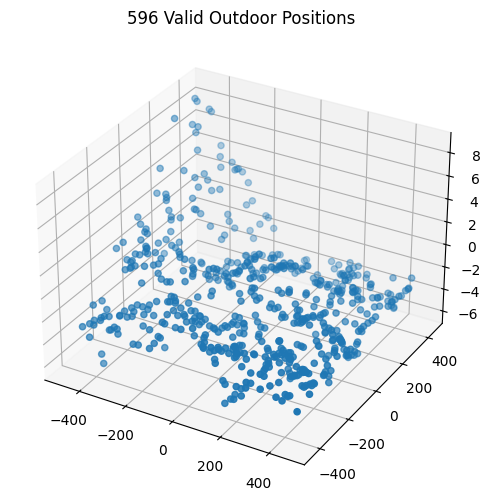

In [3]:
# Obtain the Mitsuba scene object from Sionna scene object 
mi_scene = scene.mi_scene

# Generate candidate positions (1.5m height = typical UE height)
num_candidates = 1000

# Load the terrain mesh
mesh = trimesh.load('../scenes/Boston/mesh/lidar_terrain.ply')

# Sample N points uniformly on the surface
points, face_indices = trimesh.sample.sample_surface(mesh, num_candidates)

candidates = np.asarray(points)
candidates[:, 2] += 1.5
# Create a direction vector pointing upwards (towards the sky) 
# and tile it to match the number of positions
directions_np = np.tile(np.array([0, 0, 1]), (num_candidates, 1))

# Ray tracing validation
rays = mi.Ray3f(
    # mi.Vector3f(candidates),
    mi.Vector3f(np.array(candidates, dtype=np.float32).T),
    mi.Vector3f(np.array(directions_np, dtype=np.float32).T)
)
si = mi_scene.ray_intersect(rays)
valid_mask = ~si.is_valid()

# Filter and visualize
valid_positions = candidates[valid_mask]
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(valid_positions[:,0], valid_positions[:,1], valid_positions[:,2])
ax.set_title(f"{len(valid_positions)} Valid Outdoor Positions")
plt.show()

## 3. **Configure** the transmitters (TXs) and receivers (RXs)

Next, we specify:
- The **transmit (TX)** antenna array is a planar array with a single element and isotropic pattern;
- The **receive (RX)** antenna array is a planar array with a single element but with a dipole pattern.

Then, we create a `Transmitter` object with a specific position and orientation, and add it to the `scene`. Then, 10 valid RX locations from the above step are randomly selected.

**Note: Scene geographical coordinate system**
- Coordinate system: The center of the scene is at (0,0,0), the z-axis for the flat ground polygon is 0.
- Units: Meters (m).

**Note: Sionna Azimuth/Elevation Format**
- Sionna defines the **antenna azimuth** in the range [-π, π) [rad]. The following code converts the commonly used **north-origin, clockwise-degree azimuth** to the formate suitable for Sionna. Check the code below for details.

In [4]:
# Array configurations

# Transmitter array (single isotropic element)
scene.tx_array = PlanarArray(
    num_rows=1,
    num_cols=1,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    pattern="iso",        # isotropic pattern
    polarization="V"      # vertical polarization
)

# Receive array (single dipole element)
scene.rx_array = PlanarArray(
    num_rows=1,
    num_cols=1,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    pattern="dipole",
    polarization="V"
)

# Random select 10 receivers form valid_positions (Outdoor positions)
for i, pos in enumerate(valid_positions[np.random.choice(valid_positions.shape[0], size=20, replace=False)]):
    rx = Receiver(
        name=f"rx{i}",
        position=pos,
        orientation=[0, 0, 0] 
    )
    scene.add(rx)

# Transmitter configuration
tx = Transmitter(
    name="tx",
    position=[0, 0, 100],  # Elevated position
    orientation=[-1 * (210 - 90) / 180 * np.pi, 0, 0]  # 210° azimuth tilt
)
scene.add(tx)

# Validate setup
scene.preview();

## 4. **Compute** path (rays) for each TX-RX pair

- `max_depth=3`: Set the maximum number of reflections/refractions/diffractions;
- `specular_reflection=True`: Spectular reflection is enabled;
- `diffuse_reflection=False`: Diffuse reflection is disabled;
- `refraction=False`: Refraction is disabled;
- `samples_per_src=int(1e8)`: Set the number of rays to be sampled per source.

**Note**:
Reduce the number of samples if you observe out-of-memory error.

In [5]:
# Configure simulation parameters
scene.frequency = 3.65e9  # 3.65 GHz carrier
scene.synthetic_array = True  # Optimize for array calculations

for radio_material in scene.radio_materials.values():
    radio_material.scattering_coefficient  = 0.4

# Perform ray tracing using PathSolver()
solver = PathSolver()
paths = solver(scene, max_depth=3,
    los=True,
    specular_reflection=True,
    diffuse_reflection=False,
    refraction=False,
    samples_per_src=int(1e8)
)

## 5. **Visualize** the paths (rays) using Sionna built-in functions

In [6]:
# Preview the scene with paths
scene.preview(paths=paths);

## 6. **Save** the raw information for individual paths (rays)
- `paths.a`: Complex-valued path gain;
- `paths.tau`: Path delay;
- `paths.interactions`: Path type;
- `paths.valid`: Path is valid (True) or not (False);
- `paths.phi` and `paths.theta`: Path azimuth/elevation angles with repect to the TX or RX/

In [7]:
# Parse paths into a structured dataset containing detailed rays information
def create_ray_dataset(paths, frequency):
    """Process raw ray data into pandas DataFrame"""
    dataset = {
        'freq': [],
        'rx_id': [],
        'type': [],
        'phi_r': [],
        'phi_t': [],
        'theta_r': [],
        'theta_t': [],
        'a':[],
        'tau':[],
        'rx_coord':[]
    }

    # See sionna.rt.constants.InteractionType
    ray_type_map = {0: "LOS", 1: "SPECULAR", 2: "DIFFUSE", 4: "REFRACTION"}
    
    a = np.asarray(paths.a).squeeze()
    tau = np.asarray(paths.tau).squeeze()
    types = np.asarray(paths.interactions).squeeze()
    mask = np.asarray(paths.valid).squeeze()
    phi_r = np.asarray(paths.phi_r).squeeze()
    phi_t = np.asarray(paths.phi_t).squeeze()
    theta_r = np.asarray(paths.theta_r).squeeze()
    theta_t = np.asarray(paths.theta_t).squeeze()
    
    # Extract relevant parameters
    for idx, item in enumerate(mask):
        # Filter out the RX if it has no valid paths
        if np.sum(item==True):
            for sub_idx, sub_item in enumerate(item):
                if sub_item:
                    cur_ray_type = 0
                    for depth_idx in range(3-1, -1, -1):
                        cur_ray_type = types[depth_idx,idx,sub_idx]
                        # print(f"types[{depth_idx},{idx},{sub_idx}]",cur_ray_type)
                        if cur_ray_type != 0:
                            break

                    # Store the list instead of np.array to avoid the space seperator in .csv
                    dataset["freq"].append(frequency)
                    dataset["type"].append(ray_type_map[cur_ray_type])
                    z = np.complex64(a[0,idx,sub_idx] + 1j*a[1, idx,sub_idx]) 
                    dataset["a"].append(z)
                    dataset["tau"].append(tau[idx,sub_idx])
                    dataset["rx_id"].append(idx)
                    dataset["rx_coord"].append(valid_positions[idx].tolist())
                    dataset["phi_r"].append(phi_r[idx,sub_idx ])                    
                    dataset["phi_t"].append(phi_t[idx,sub_idx])
                    dataset["theta_r"].append(theta_r[idx,sub_idx])
                    dataset["theta_t"].append(theta_t[idx,sub_idx])
    
    return pd.DataFrame(dataset)

# Generate analysis dataframe
df = create_ray_dataset(paths, frequency=3.65e9)
df.head()

,freq,rx_id,type,phi_r,phi_t,theta_r,theta_t,a,tau,rx_coord
0,3.650000e+09,1,SPECULAR,-2.651839,-1.525616,1.705858,1.715034,0.000001+0.000000j,0.000002,"[-65.13722762566769, 121.5557225140514, -2.327..."
1,3.650000e+09,1,SPECULAR,-2.747795,-1.710153,1.440165,1.701428,-0.000004+0.000000j,0.000003,"[-65.13722762566769, 121.5557225140514, -2.327..."
2,3.650000e+09,1,SPECULAR,-2.651152,-1.525607,1.430241,1.711352,-0.000005+0.000000j,0.000002,"[-65.13722762566769, 121.5557225140514, -2.327..."
3,3.650000e+09,4,SPECULAR,2.673730,0.809750,1.382437,1.759156,-0.000007-0.000000j,0.000002,"[133.35354737340026, -254.87072240377944, -2.6..."
4,3.650000e+09,4,SPECULAR,2.640835,0.808661,1.650173,1.767765,0.000002+0.000000j,0.000002,"[133.35354737340026, -254.87072240377944, -2.6..."


## 7. **Analyze** the generated paths

The examples below provide the following analysis:
- A histogram with respect to different path types;
- CDF of the path gain.

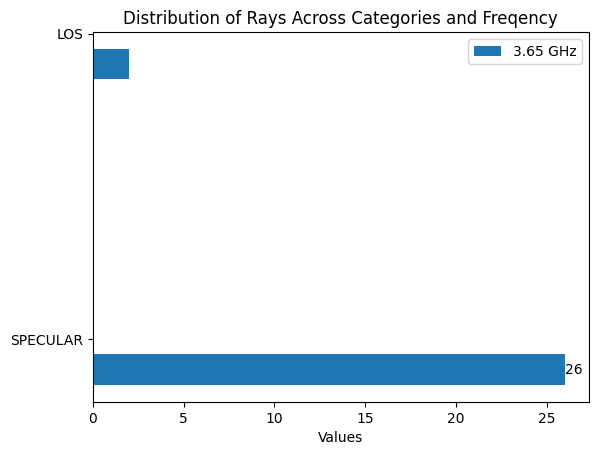

In [8]:
import matplotlib.pyplot as plt

# Get distinct values of ray types
distinct_types = df['type'].unique()

# Get distinct values of freq
distinct_freqs = df['freq'].unique()

values = []
for freq in distinct_freqs:
    tmp_value = []
    for ray_type in distinct_types:
        tmp_value.append(len( df.query("freq == {} and type == '{}'".format(freq, ray_type)) ))
    values.append(tmp_value)
values = np.array(values)

# Create an array for the positions of each group
group_positions = np.arange(len(distinct_types))

# Width of each bar
bar_width = 0.1

# Creating the horizontal bar chart
fig, ax = plt.subplots()

for i in range(len(distinct_freqs)):
    # Position of the bars on the x-axis
    positions = group_positions + i * bar_width
    ax.barh(positions, values[i,:], height=bar_width, label="{} GHz".format(distinct_freqs[i]/1e9))

# Adding labels
ax.set_yticks(group_positions + bar_width)
ax.set_yticklabels(distinct_types)
ax.set_xlabel('Values')
ax.set_title('Distribution of Rays Across Categories and Freqency')

# Adding value labels on top of the bars
for i in range(len(distinct_freqs)):
    for j in range(len(distinct_freqs)):
        ax.text(values[i, j], j + i * bar_width, str(values[i, j]), va='center')

# Adding legend
ax.legend()

# Adding legend with reversed order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

# Display the chart
plt.show()

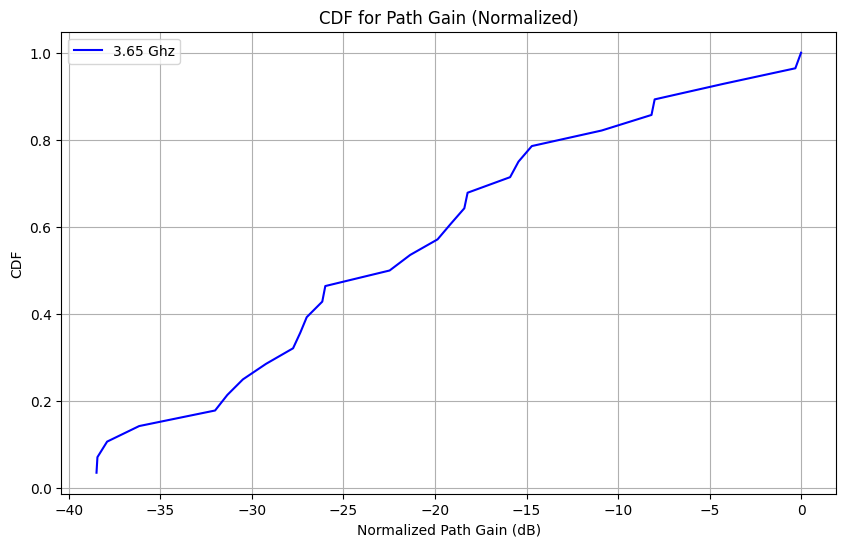

In [9]:
def multi_cdf(data_df, target_column, title,  x_label = 'Value', y_label = 'CDF', normalized=False):
    # Get distinct values of ray types
    distinct_types = df['type'].unique()
    
    # Get distinct values of freq
    distinct_freqs = df['freq'].unique()

    colors = ["blue","green", "red"]

    # Function to compute CDF
    def compute_cdf(data):
        if len(data) == 1:
            # Special case for single data point
            data_sorted = np.array([data[0], data[0]])
            cdf = np.array([0, 1])
        else:
            data_sorted = np.sort(data)
            cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
        return data_sorted, cdf
    
    # Plotting the CDFs
    plt.figure(figsize=(10, 6))
    for i, freq in enumerate(distinct_freqs):
        tmp_df = data_df.query("freq == {} and type!= 3".format(freq))
        
        if normalized:
            tmp_df.loc[:,target_column] = tmp_df[target_column] - tmp_df[target_column].max()

        # Compute CDFs for each class
        tmp_x, tmp_cdf = compute_cdf( tmp_df[target_column].to_list())
        plt.plot(tmp_x, tmp_cdf, label="{} Ghz".format(freq/1e9), color=colors[i])
    
    # Adding titles and labels
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    
    # Display the plot
    plt.show()

# Path Gain
tmp_df = df[['freq', 'a', 'type']].copy()
tmp_df.loc[:,'pathGain'] = 20*np.log10(np.abs(tmp_df['a']))
multi_cdf(tmp_df, "pathGain", "CDF for Path Gain (Normalized)", "Normalized Path Gain (dB)", normalized = True)

## 8. **Link-level Simulations** using generated channel impulse response (CIR).

The example below generates the CIR for a given RX location, which is then used to generate a time-domain channel for link-level simulation using single-carrier modulation (e.g., M-QAM).

# of valid paths for RX-1: 3


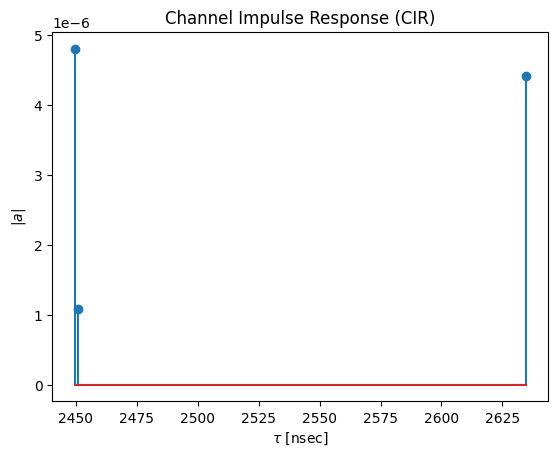

In [55]:
num_rx = np.asarray(paths.a).shape[1]

# Count the number of paths associated with each RX ID in the dataframe,
# sorted in descending order (most frequent RX comes first)
rx_counts_ordered = df["rx_id"].value_counts()

# Select the RX ID with the maximum number of associated paths (first in the sorted list)
# to use for computing the channel impulse response (CIR)
tmp_rx_idx = rx_counts_ordered.keys()[4]

# For a given RX, parse paths to generate
# - tmp_rx_a is in the dimension of [2, num_paths]
# - tmp_rx_tau in the dimension of [num_paths]
# - tmp_rx_valid in the dimension of [num_paths]
tmp_rx_a = np.asarray(paths.a)[:,tmp_rx_idx,:,:,:,:].squeeze()
tmp_rx_tau = np.asarray(paths.tau)[tmp_rx_idx,:,:].squeeze()
tmp_rx_valid = np.asarray(paths.valid)[tmp_rx_idx,:,:].squeeze()

if np.sum(tmp_rx_valid) <= 0:
    print(f"No valid paths for RX-{tmp_rx_idx}.")

else:
    print(f"# of valid paths for RX-{tmp_rx_idx}: {np.sum(tmp_rx_valid)}")
    t = tmp_rx_tau[tmp_rx_valid]/1e-9 # Scale to nsec
    a_abs = np.sqrt(tmp_rx_a[0, tmp_rx_valid]**2 + tmp_rx_a[1, tmp_rx_valid]**2)
    a_max = np.max(a_abs)

    # Plot the CIR
    plt.figure()
    plt.title("Channel Impulse Response (CIR)")
    plt.stem(t, a_abs)
    plt.xlabel(r"$\tau$ [nsec]")
    # plt.xlim([-0.1, np.max(t)*1.1])
    plt.ylabel(r"$|a|$");
    # plt.ylim([0, np.max(a_abs)*1.1])

    
# # Compute the corresponding channel frequency response (CFR)
# from sionna.rt import subcarrier_frequencies

# # Number of subcarriers and subcarrier spacing (scs) in Hz
# num_scs = 64
# scs = 30e3

# # Compute frequencies of subcarriers relative to the carrier frequency
# freq = subcarrier_frequencies(num_scs, scs)

# # Compute channel frequency response (CFR)
# # Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
# h_freq = paths.cfr(frequencies=freq,
#                    normalize=True, # Normalize energy
#                    normalize_delays=True,
#                    out_type="numpy")

# h_freq_tmp_rx = h_freq.squeeze()[tmp_rx_idx, :]

# if np.sum(tmp_rx_valid) <= 0:
#     print(f"No valid paths for RX-{tmp_rx_idx}.")

# else:
#     # Plot the CFR
#     plt.figure()
#     plt.title("Channel Frequency Response (CFR)");
#     plt.plot(np.abs(h_freq_tmp_rx));
#     plt.xlabel("Subcarrier Index");
#     plt.ylabel(r"|$h_\text{freq}$| (dB)");

#     plt.figure()
#     plt.title("Channel Frequency Response (CFR)");
#     plt.plot(np.degrees(np.angle(h_freq_tmp_rx)));
#     plt.xlabel("Subcarrier Index");
#     plt.ylabel(r"Phase (Degree)");

Channel power delay profile (PDP):
tau_min: 2.4495891466358444e-06, tau_max: 2.634497377584921e-06
tau_mean: 8.235189596916825e-08, tau_rms: 9.186701740170142e-08

Generated time-domain channels from CIR:
h_time length: 14
Signal bandwidth: 1000.0 Hz, T_sym: 1000.00 usec
Coherence bandwidth: 2177059.90 Hz

Phase of combined channel: -169.76 deg
Phase estimated using 1st symbol: 177.40 deg

Bit error rate (BER) at 30.0 dB SNR: 0.000000


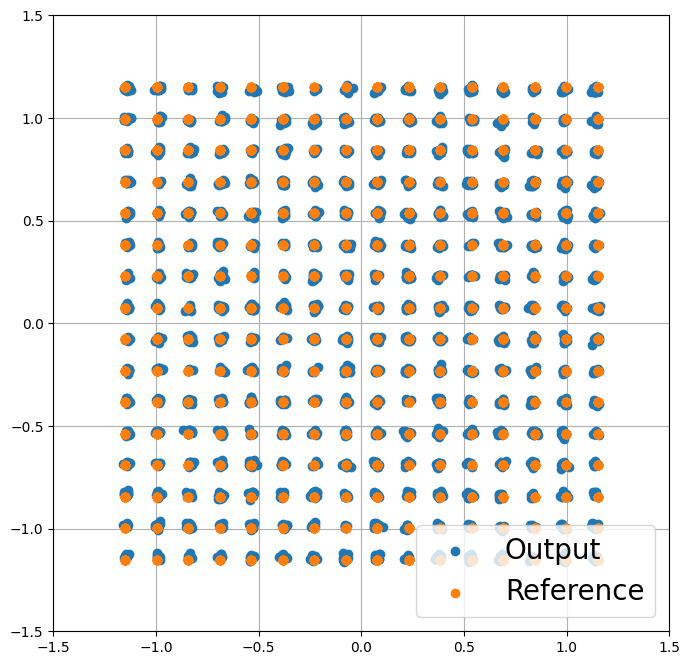

In [63]:
import tensorflow as tf

from sionna.phy.mapping import BinarySource, Constellation, Mapper, Demapper
from sionna.phy.channel import AWGN, time_lag_discrete_time_channel, cir_to_time_channel, ApplyTimeChannel
from sionna.phy.utils import ebnodb2no, compute_ser

# 256-QAM constellation
NUM_BITS_PER_SYMBOL = 8

# Define mapper and demapper
mapper = Mapper("qam", NUM_BITS_PER_SYMBOL)
demapper = Demapper("app", "qam", NUM_BITS_PER_SYMBOL, hard_out=True)

BATCH_SIZE = 1 # How many examples are processed by Sionna in parallel
EBN0_DB = 30.0 # Eb/N0 in dB

no = ebnodb2no(ebno_db=EBN0_DB,
               num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
               coderate=1.0) # uncoded transmission

binary_source = BinarySource()
input_bits = binary_source([BATCH_SIZE, 24000])
x = mapper(input_bits)

# CIR to time-domain channel for single carrier modulation
tmp_rx_path_valid = tmp_rx_tau>0

tmp_rx_a_cpx = tmp_rx_a[0] + 1j * tmp_rx_a[1]
tmp_rx_a_cpx_valid = tmp_rx_a_cpx[tmp_rx_path_valid]
tmp_rx_tau_valid = tmp_rx_tau[tmp_rx_path_valid]
# Normalize path delay so that the earliest arrival path has tau = 0.0
tmp_rx_tau_valid_norm = tmp_rx_tau_valid - np.min(tmp_rx_tau_valid)

if len(tmp_rx_a_cpx_valid) != np.sum(tmp_rx_path_valid) or len(tmp_rx_tau_valid) != np.sum(tmp_rx_path_valid):
    print("Invalid number of paths!")
    sys.exit()
else:
    rx_num_paths = len(tmp_rx_a_cpx_valid)

# Combined channel h(tau)
tmp_rx_cir_combined = np.sum(tmp_rx_a_cpx_valid * np.exp(-1j * 2*np.pi * 3.65e9 * tmp_rx_tau_valid))

tmp_rx_tau_mean = np.sum(np.abs(tmp_rx_a_cpx_valid)**2 * tmp_rx_tau_valid_norm) / np.sum(np.abs(tmp_rx_a_cpx_valid)**2)
tmp_rx_tau_sq_mean = np.sum(np.abs(tmp_rx_a_cpx_valid)**2 * tmp_rx_tau_valid_norm**2) / np.sum(np.abs(tmp_rx_a_cpx_valid)**2)
tmp_rx_tau_rms = np.sqrt(tmp_rx_tau_sq_mean - tmp_rx_tau_mean**2)

# Convert a and tau to the correct tensor form required for cir_to_time_channel()
tmp_rx_a_tf = tf.convert_to_tensor(tmp_rx_a_cpx_valid, dtype=tf.complex64)
tmp_rx_a_tf = tf.reshape(tmp_rx_a_tf, [1, 1, 1, 1, 1, len(tmp_rx_a_cpx_valid), 1])
tmp_rx_tau_tf = tf.convert_to_tensor(tmp_rx_tau_valid, dtype=tf.float32)
tmp_rx_tau_tf = tf.reshape(tmp_rx_tau_valid, [1, 1, 1, 1, 1, len(tmp_rx_tau_valid)])

# Print power delay profile (PDP) statistics
print(f"Channel power delay profile (PDP):")
print(f"tau_min: {np.min(tmp_rx_tau_tf)}, tau_max: {np.max(tmp_rx_tau_tf)}")
print(f"tau_mean: {tmp_rx_tau_mean}, tau_rms: {tmp_rx_tau_rms}\n")

# Consider a time-domain channel using sinc() pulse shaping with given bandwidth
bandwidth = 1e3 # in Hz
l_min, l_max = time_lag_discrete_time_channel(bandwidth=bandwidth,
                                              maximum_delay_spread=3e-6)

h_time_domain = cir_to_time_channel(bandwidth=bandwidth,
                                    a=tmp_rx_a_tf,
                                    tau=tmp_rx_tau_tf,
                                    l_min=l_min,
                                    l_max=l_max,
                                    normalize=True)

print(f"Generated time-domain channels from CIR:")
print(f"h_time length: {l_max-l_min+1}")
print(f"Signal bandwidth: {bandwidth} Hz, T_sym: {1.0/bandwidth*1e6:.2f} usec")
print(f"Coherence bandwidth: {1.0/(5.0*tmp_rx_tau_rms):.2f} Hz\n")

apply_channel = ApplyTimeChannel(num_time_samples=x.shape[1],
                                 l_tot=l_max-l_min+1,
                                 precision="single")

x_reshaped = tf.reshape(x, [x.shape[0], 1, 1, x.shape[1]])
y = apply_channel(x_reshaped, h_time_domain, no)
y = tf.squeeze(y, axis=[0, 1, 2])
y = y[-l_min:-l_max] # Truncate the channel output to match with input length

# Use the 1st M-QAM symbol for channel estimation
x_np = np.asarray(x).squeeze()
y_np = np.asarray(y).squeeze()
csi_sym0 = y_np[0]/x_np[0]
print(f"Phase of combined channel: {np.angle(tmp_rx_cir_combined)/np.pi*180.0:.2f} deg")
print(f"Phase estimated using 1st symbol: {np.angle(csi_sym0)/np.pi*180.0:.2f} deg\n")
# Apply inverse CSI
y = y / csi_sym0

# AWGN channel
# awgn_channel = AWGN()
# y = awgn_channel(x, no)

# Hard output LLR in bits
llr = demapper(y, no)

# Compute BER and plot constellations
ser = compute_ser(input_bits, llr)
print(f"Bit error rate (BER) at {EBN0_DB} dB SNR: {ser.numpy():.6f}")

plt.close('all')
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1.0)
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.grid(True, zorder=0)
plt.scatter(tf.math.real(y), tf.math.imag(y), label="Output", zorder=2)
plt.scatter(tf.math.real(x), tf.math.imag(x), label="Reference", zorder=2)
plt.legend(fontsize=20, loc="lower right");
plt.show()

**Closing Remark**:
Please refer to the [Sionna Documentation](https://nvlabs.github.io/sionna/) for more advanced features!